TASK 1

Pattern Substitution Risk

Problem statement​
You are given a binary (black-and-white) document image containing repeated characters. Write a program that:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.measure import label, regionprops
from skimage.morphology import opening, square

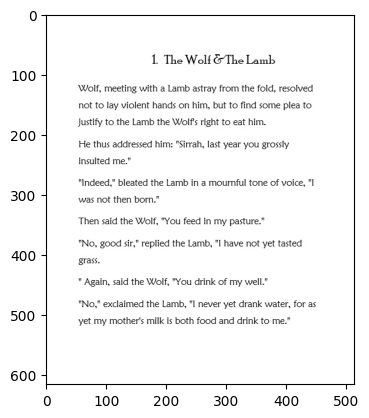

In [2]:

img = cv2.imread("short_story.jpg", cv2.IMREAD_GRAYSCALE)# grayscale
# make sure it's binary

_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img, cmap='gray')

extract characters

In [3]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, 8)

print("Total characters:", num_labels - 1)


Total characters: 530


drawing box

In [4]:
characters = []
MIN_AREA = 50   # noise filter

for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]

    if area < MIN_AREA:
        continue

    char_img = binary[y:y+h, x:x+w]

    characters.append({
        "bbox": (x, y, w, h),
        "img": char_img
    })



Extract Characters

In [5]:
def pixel_iou(img1, img2, size=(32, 32)):
    i1 = cv2.resize(img1, size) > 0
    i2 = cv2.resize(img2, size) > 0

    inter = np.logical_and(i1, i2).sum()
    union = np.logical_or(i1, i2).sum()

    return inter / union if union != 0 else 0


SSIM ccore checks luminance, contrast and stucture

we are doing this how image compression changes the visual structure of digits

In [6]:
def ssim_score(img1, img2, size=(32, 32)):
    i1 = cv2.resize(img1, size)
    i2 = cv2.resize(img2, size)
    return ssim(i1, i2, data_range=255)


now we decide whether two characters are the same after compression.

In [7]:
def same_character(c1, c2, iou_th=0.60, ssim_th=0.60):
    #pixel overlap bw to image 
    iou = pixel_iou(c1["img"], c2["img"])
    ssim_val = ssim_score(c1["img"], c2["img"])
    return (iou >= iou_th) and (ssim_val >= ssim_th)

here we are grouping similar characters together

In [8]:
groups = []

for char in characters:
    placed = False

    for group in groups:
        rep = group[0]  # representative
        if same_character(char, rep):
            group.append(char)
            placed = True
            break

    if not placed:
        groups.append([char])

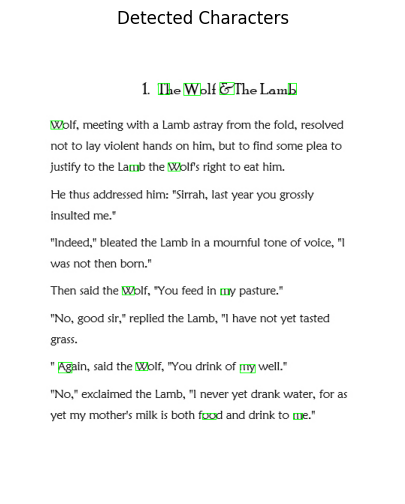

In [9]:
boxed = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for c in characters:
    x, y, w, h = c["bbox"]
    cv2.rectangle(boxed, (x, y), (x+w, y+h), (0,255,0), 1)

plt.figure(figsize=(8,6))
plt.title("Detected Characters")
plt.imshow(boxed, cmap="gray")
plt.axis("off")
plt.show()

To visually verify whether the characters grouped together are actually the same or not

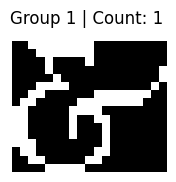

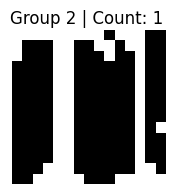

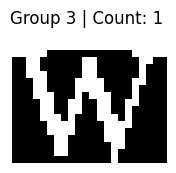

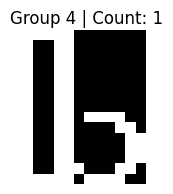

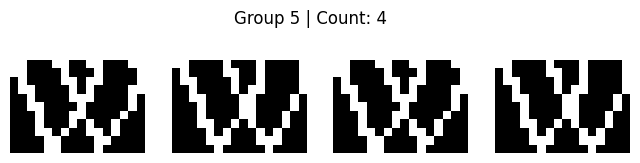

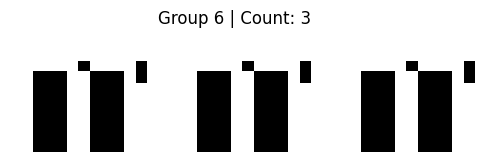

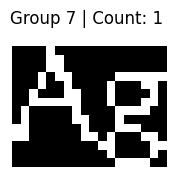

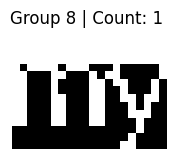

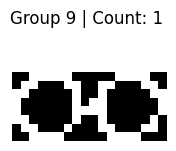

In [10]:
# Loop over each group of similar characters with an index
for idx, group in enumerate(groups):
    plt.figure(figsize=(len(group)*2, 2))
    plt.suptitle(f"Group {idx+1} | Count: {len(group)}")

    for i, char in enumerate(group):
        plt.subplot(1, len(group), i+1)
        plt.imshow(char["img"], cmap="gray")
        plt.axis("off")

    plt.show()

TASK 2

Human-Visible vs Machine-Relevant Differences

Problem statement​
Take a grayscale image with text or fine patterns. Generate multiple compressed versions using JPEG at different quality levels.

In [11]:
img = cv2.imread("blue_pattern.jpg", cv2.IMREAD_GRAYSCALE)

Save JPEG Images at Different Quality

In [12]:
qualities = [100,80, 50, 30, 10]
compressed_images = []

for q in qualities:
    filename = f"jpeg_q{q}.jpg"
    cv2.imwrite(filename, img, [cv2.IMWRITE_JPEG_QUALITY, q])
    comp = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    compressed_images.append(comp)


compute PSNR

PSNR tells how much noise added by compression.

In [13]:
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255 / np.sqrt(mse))


Compute SSIM

SSIM tells visual similarity

In [14]:
def get_ssim(img1, img2):
    score, _ = ssim(img1, img2, full=True)
    return score

Apply Edge Detection used canny

In [15]:
edges_original = cv2.Canny(img, 100, 200)

edges_compressed = []
for c in compressed_images:
    e = cv2.Canny(c, 100, 200)
    edges_compressed.append(e)


Print PSNR & SSIM Values

In [16]:
for i, q in enumerate(qualities):
    p = psnr(img, compressed_images[i])
    s = get_ssim(img, compressed_images[i])
    print(f"Quality {q}: PSNR = {p:.2f}, SSIM = {s:.4f}")


Quality 100: PSNR = 59.28, SSIM = 1.0000
Quality 80: PSNR = 35.76, SSIM = 0.9901
Quality 50: PSNR = 30.48, SSIM = 0.9659
Quality 30: PSNR = 29.33, SSIM = 0.9411
Quality 10: PSNR = 28.49, SSIM = 0.8651


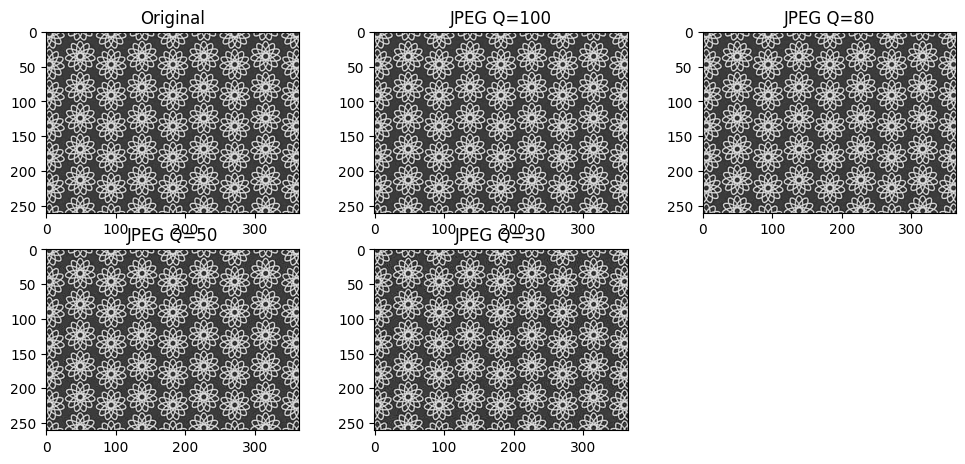

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.subplot(3,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")

for i, q in enumerate(qualities[:4]):
    plt.subplot(3,3,i+2)
    plt.imshow(compressed_images[i], cmap='gray')
    plt.title(f"JPEG Q={q}")

plt.show()


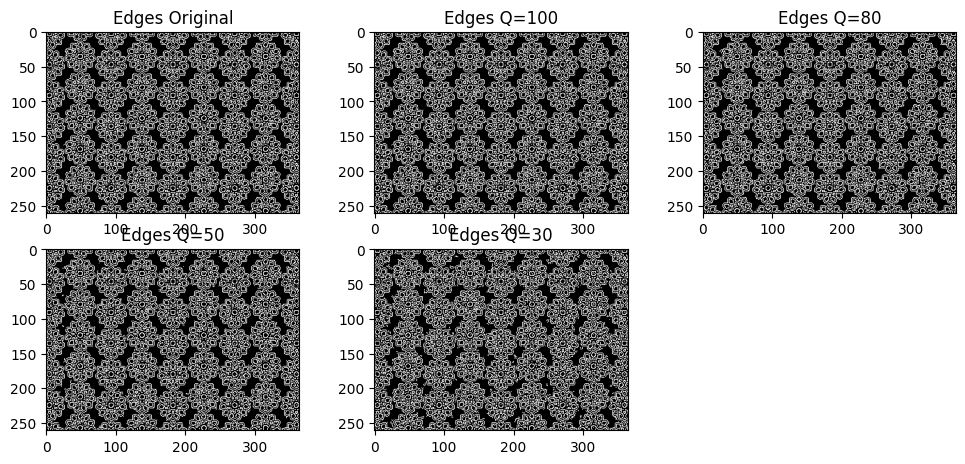

In [18]:
plt.figure(figsize=(12,8))

plt.subplot(3,3,1)
plt.imshow(edges_original, cmap='gray')
plt.title("Edges Original")

for i, q in enumerate(qualities[:4]):
    plt.subplot(3,3,i+2)
    plt.imshow(edges_compressed[i], cmap='gray')
    plt.title(f"Edges Q={q}")

plt.show()


PSNR & SSIM=Both decrease when compression increases.
            SSIM drops faster when fine details are lost.

edge Detection=At low quality, edges become broken.
                Fine text strokes disappear.
                OCR preprocessing becomes unreliable

TASK 3

Silent Data Corruption Detection

Problem statement​
You are given two scanned versions of the same document:​

One compressed using a safe lossless method​

One compressed using a lossy method​

Both look visually similar.

In [23]:
img_lossless = cv2.imread("lossely.png", cv2.IMREAD_GRAYSCALE)
img_lossy    = cv2.imread("doc_lossy.png", cv2.IMREAD_GRAYSCALE)

Extract Connected Components (Characters)

We’ll use bounding boxes easy

Each stats contains:
x, y, width, height, area of each component

Lossy compression often reduces stroke thickness → area changes.

Number of distorted regions: 366
Average distortion area: 788.7213114754098


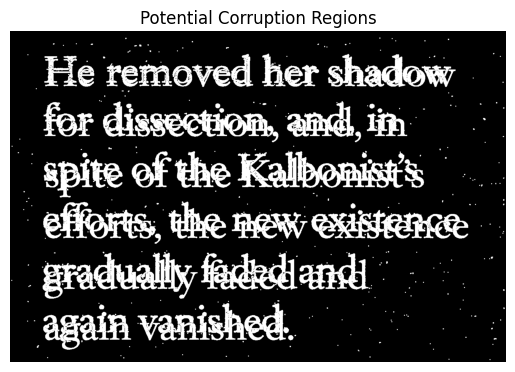

In [24]:
lossless = cv2.imread("loosly.jpeg", cv2.IMREAD_GRAYSCALE) 

lossy = cv2.imread("doc_loosly.jpeg", cv2.IMREAD_GRAYSCALE) 

diff = cv2.absdiff(lossless, lossy) 

_, diff_bin = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY) 

kernel = np.ones((3,3), np.uint8) 

diff_bin = cv2.morphologyEx(diff_bin, cv2.MORPH_OPEN, kernel) 

num, labels, stats, _ = cv2.connectedComponentsWithStats(diff_bin, 8)

print("Number of distorted regions:", num - 1)

areas = stats[1:, cv2.CC_STAT_AREA]
print("Average distortion area:", np.mean(areas))
plt.imshow(diff_bin, cmap='gray') 

plt.title("Potential Corruption Regions") 

plt.axis("off") 

plt.show()

Lossy compression introduces small pixel variations in background which also appear in difference image.
These can be reduced using stronger morphological filtering.

The text looks “overlapped” because

you are seeing the difference between two versions of the same text where:

edges have shifted slightly

strokes became thicker or thinner

blur caused character boundaries to move

So both versions don’t match pixel-to-pixel, and the difference image highlights both edge positions, which looks like overlapping letters.

TASK 4

When Compression Breaks a Downstream
Problem statement​
Build a simple rule-based digit or character recognizer (not deep learning). Test it on:​

Original document images​

Heavily compressed versions

Recognition accuracy after compression: 1.00


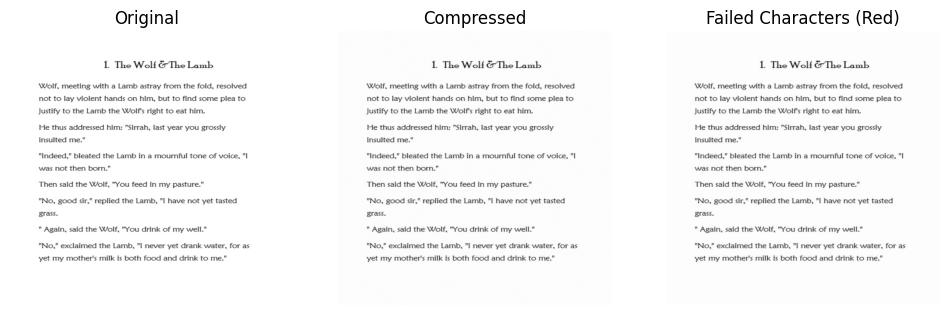

In [25]:
import cv2, numpy as np, matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# -----------------------------
# 1. LOAD ORIGINAL IMAGE
# -----------------------------
img = cv2.imread("short_story.jpg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found")

# resize for consistency
img = cv2.resize(img, (900, 900))

# -----------------------------
# 2. CREATE COMPRESSED VERSION
# -----------------------------
params = [int(cv2.IMWRITE_JPEG_QUALITY), 20]   # heavy compression
_, enc = cv2.imencode(".jpg", img, params)
img_comp = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

# -----------------------------
# 3. BINARIZATION
# -----------------------------
_, bin_orig = cv2.threshold(img, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, bin_comp = cv2.threshold(img_comp, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# -----------------------------
# 4. SIMPLE RULE-BASED CLASSIFIER
# -----------------------------
def simple_classifier(region):
    h, w = region.shape
    ratio = h / (w + 1e-5)

    if ratio > 2.5:
        return "1/I"
    elif ratio < 1.0:
        return "O/0"
    elif 1.2 < ratio < 1.8:
        return "E/F/H"
    else:
        return "OTHER"

# -----------------------------
# 5. CONNECTED COMPONENT ANALYSIS
# -----------------------------
def classify_image(bin_img):
    labels = label(bin_img)
    preds = []

    for r in regionprops(labels):
        if r.area < 200:   # remove noise
            continue
        region = bin_img[r.slice]
        pred = simple_classifier(region)
        preds.append((r.bbox, pred))
    return preds

pred_orig = classify_image(bin_orig)
pred_comp = classify_image(bin_comp)

# -----------------------------
# 6. ACCURACY MEASUREMENT
# -----------------------------
total = min(len(pred_orig), len(pred_comp))
correct = 0
failed_boxes = []

for i in range(total):
    if pred_orig[i][1] == pred_comp[i][1]:
        correct += 1
    else:
        failed_boxes.append(pred_comp[i][0])

accuracy = correct / total if total > 0 else 0
print(f"Recognition accuracy after compression: {accuracy:.2f}")

# -----------------------------
# 7. VISUALIZE FAILURES
# -----------------------------
vis = cv2.cvtColor(img_comp, cv2.COLOR_GRAY2BGR)

for (y0, x0, y1, x1) in failed_boxes:
    cv2.rectangle(vis, (x0, y0), (x1, y1), (0,0,255), 2)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Compressed")
plt.imshow(img_comp, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Failed Characters (Red)")
plt.imshow(vis, cmap="gray")
plt.axis("off")

plt.show()

TASK 5

Designing a “Safe Compression” Rule

Problem statement​
Design a simple heuristic to decide whether a document image should be:​

Compressed losslessly​

Compressed lossily​

Not compressed at all

In [26]:
def image_entropy(image):
    hist = np.histogram(image.flatten(), bins=256, range=(0,256))[0]
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))


In [27]:
def edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0) / edges.size


In [28]:
def component_density(image):
    _, bin_img = cv2.threshold(image, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(bin_img) > 127:   # text usually dark
        bin_img = 255 - bin_img

    labels = label(bin_img)
    count = 0
    for r in regionprops(labels):
        if r.area > 50:
            count += 1
    return count / image.size


In [29]:
def compression_decision(image):

    e = image_entropy(image)
    d = edge_density(image)
    c = component_density(image)

    print(f"Entropy={e:.2f}, EdgeDensity={d:.3f}, CompDensity={c:.5f}")

    # Very sensitive documents
    if d > 0.18 and c > 0.0005:
        return "DO NOT COMPRESS (or use PNG/TIFF)"

    # Normal text / forms
    elif d > 0.10 or c > 0.0003:
        return "USE LOSSLESS COMPRESSION"

    # Photos or smooth images
    else:
        return "LOSSY COMPRESSION SAFE (JPEG)"


In [30]:
img_text = cv2.imread("short_story.jpg",     cv2.IMREAD_GRAYSCALE)
img_photo  = cv2.imread("fish.jpg",  cv2.IMREAD_GRAYSCALE)
img_form  = cv2.imread("digits.jpg",      cv2.IMREAD_GRAYSCALE)

print("Photo Image:", compression_decision(img_photo))
print("Text Image:",  compression_decision(img_text))
print("Form Image:",  compression_decision(img_form))



Entropy=6.66, EdgeDensity=0.065, CompDensity=0.00004
Photo Image: LOSSY COMPRESSION SAFE (JPEG)
Entropy=0.70, EdgeDensity=0.050, CompDensity=0.00007
Text Image: LOSSY COMPRESSION SAFE (JPEG)
Entropy=3.08, EdgeDensity=0.033, CompDensity=0.00008
Form Image: LOSSY COMPRESSION SAFE (JPEG)


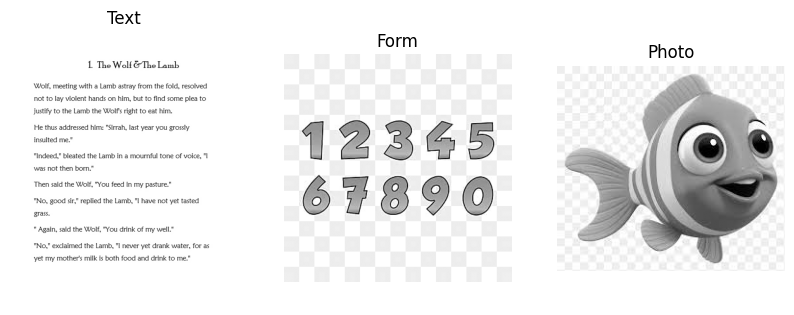

In [31]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1); plt.imshow(img_text, cmap='gray');  plt.title("Text");  plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_form, cmap='gray');  plt.title("Form");  plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_photo, cmap='gray'); plt.title("Photo"); plt.axis('off')

plt.show()
